# DataLab Cup 2: CNN for Object Detection

In [1]:
import tensorflow as tf
import numpy as np

from data_aug.data_aug import *
from data_aug.bbox_util import *

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        # for gpu in gpus:
        #     tf.config.experimental.set_memory_growth(gpu, True)
        #     tf.config.experimental.set_visible_devices(gpu[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Select GPU number 1
        # tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [4]:
training_data_file = open("./dataset/pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i >5:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


## Hyperparameters

In [5]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 1
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './dataset/pascal_voc_training_data.txt'
IMAGE_DIR = './dataset/VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 10

## Show training data distribution

In [6]:
image_names = []
record_list = []
object_num_list = []
# filling the record_list
input_file = open(DATA_PATH, 'r')

for line in input_file:
    line = line.strip()
    ss = line.split(' ')
    image_names.append(ss[0])

    record_list.append([float(num) for num in ss[1:]])

    object_num_list.append(min(len(record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
    if len(record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
        # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
        record_list[-1] = record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(record_list[-1])//5)
                
    elif len(record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
        record_list[-1] = record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]

In [7]:
c = []
for i in range(len(image_names)):
    n = object_num_list[i]
    for j in range(n):
        if j == 0 :
            c.append(record_list[i][4])
        else:
            c.append(record_list[i][((j+1)*5)-1])

# c

In [8]:
each_class_num = []
for i in range(20):
    each_class_num.append(c.count(i))
    print(classes_name[i], ' ', each_class_num[i])

aeroplane   331
bicycle   412
bird   577
boat   398
bottle   612
bus   271
car   1634
cat   389
chair   1423
cow   356
diningtable   309
dog   536
horse   403
motorbike   387
person   5318
pottedplant   603
sheep   353
sofa   419
train   328
tvmonitor   366


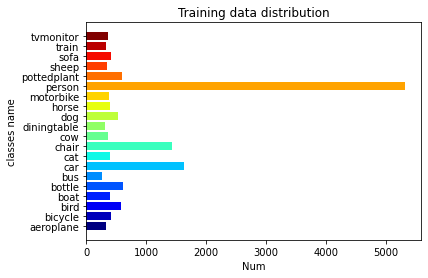

In [9]:
from matplotlib import cm
cmap = cm.jet(np.linspace(0, 1, len(classes_name)))
plt.barh(classes_name, each_class_num, color=cmap)
plt.ylabel('classes name')
plt.xlabel('Num')
plt.title('Training data distribution')
plt.show()

## Dataset Loader

In [10]:
image_names = []
record_list = []
object_num_list = []
# filling the record_list
input_file = open(DATA_PATH, 'r')

for line in input_file:
    line = line.strip()
    ss = line.split(' ')
    image_names.append(ss[0])

    record_list.append([float(num) for num in ss[1:]])

    object_num_list.append(min(len(record_list[-1])//5, MAX_OBJECTS_PER_IMAGE))
    if len(record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1] +\
        [0., 0., 0., 0., 0.]*\
        (MAX_OBJECTS_PER_IMAGE-len(record_list[-1])//5)
    elif len(record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
        record_list[-1] = record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
        
def update_bboxes(bbox):

    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    label = bbox[4]
    
    return [xmin,ymax,xmax,ymin,label]
    
# 判斷object是什麼
object_class = []
for i in range(len(record_list)):
    object_class2 = []
    k = 4
    for j in range(object_num_list[i]):
        object_class2.append(str(int(record_list[i][k])))
        k += 5
    object_class.append(object_class2)
    

# 得到bounding box
bboxes_list_raw = []
for i in range(len(record_list)):
    count = 0
    bboxes = []
    for j in range(int(len(record_list[i])/5)):
        bboxes.append(record_list[i][count:count + 5])
        count += 5
    bboxes = np.array([update_bboxes(k) for k in bboxes])
    bboxes_list_raw.append(bboxes)

bboxes_list_raw = dict(zip(image_names,bboxes_list_raw))


In [11]:
# # a = sum([(i == '8') for i in object_class[0]])
# # print(a)
# object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_class[2]]) > 1
# object_no_aug

In [11]:
# 判斷是否要 data augmentation
def counter_for_10(object_list):
    # print(object_list)
    object_strongaug_aug = sum([(i == '10') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 1
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_for_special(object_list):
    object_strongaug_aug = sum([(i == '1' or i == '10' or i == '12' or i == '13' or i == '5') for i in object_list]) > 0
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    if object_strongaug_aug and not object_no_aug:
      return  True
    else:
      return False

def counter_element_strong(object_list):
    # 8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '8' or i == '6' or i == '14') for i in object_list]) > 0
    if object_no_aug:
      return False
    else:
      return True

def counter_element(object_list):

    # 非14,非8,非6的物件(需要aug的為0)
    object_need_aug = sum([(i != '14' and  i != '8' and i != '6') for i in object_list]) == 0
    # 14,8,6物件(有不需要aug的)
    object_no_aug = sum([(i == '6' or i == '8' or i == '14') for i in object_list]) > 0
    # 14是否過多
    object_much_14 = sum([i == '14' for i in object_list]) > 0
    # 8是否過多
    #object_much_8 = sum([i == '8' for i in object_list]) > 1
    #object_10 = sum([i == '10' for i in object_list]) < 0

    if (object_need_aug and object_need_aug) or object_much_14:
        return False
    else:
        return True

# aug name
aug_names = []

for i in range(int(len(object_class))):
    if counter_for_10(object_class[i]):
        for j in range(20):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_for_special(object_class[i]) == True:
        for j in range(15):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element_strong(object_class[i]) == True:
        for j in range(10):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    elif counter_element(object_class[i]) == True:
        for j in range(4):
            aug_names.append('aug' + "_" + str(j) + "_" + image_names[i])
    else:
        aug_names.append("aug" + "_" + '0' + "_" + image_names[i])

In [12]:
# Augmentation parameter

np.random.seed(77)
# HSV
H = np.random.randint(60,size = len(aug_names))
S = np.random.randint(60,size = len(aug_names))
V = np.random.randint(60,size = len(aug_names))

# HorizontalFlip
flip = np.random.binomial(1, 0.5, len(aug_names))

# Scale
scale1 = np.random.uniform(-0.15,0.15,len(aug_names))
scale2 = np.random.uniform(-0.15,0.15,len(aug_names))

# Shear
shear = np.random.uniform(-0.15,0.15,len(aug_names))


random_parameter = dict(zip(aug_names,list(zip(H,S,V,flip,scale1,scale2,shear))))


image_object_dict = dict(zip(image_names,object_num_list))

In [13]:
def get_balance_augmentation():
    #count = 0
    for count in range(len(aug_names)):
        aug_name_list = aug_names[count].split('_')
        object_num = image_object_dict.get(aug_name_list[2])

        
        #若為０則生成原圖
        if aug_name_list[1] == "0":
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            
            count +=1
            
        # 否則生成變化圖
        else:
            parameter = random_parameter.get(aug_names[count])
            path = IMAGE_DIR +''+ aug_name_list[2]
            img_file = tf.io.read_file(path)
            img = tf.io.decode_jpeg(img_file, channels=3)
            
            bboxes = bboxes_list_raw.get(aug_name_list[2])
            seq = Sequence([RandomHSV((parameter[0],parameter[0]), (parameter[1],parameter[1]), (parameter[2],parameter[2])),
                            RandomHorizontalFlip(parameter[3]), Scale(parameter[4],parameter[5]), Shear(parameter[6])])
            img, bboxes = seq(img.numpy().copy(), bboxes.copy())
            
        if bboxes.shape[0] != 20:
            bboxes = np.concatenate([bboxes,np.zeros((20 - bboxes.shape[0] ,5))],axis = 0)
            
            count +=1
            
        # map function
        h = tf.shape(img)[0]
        w = tf.shape(img)[1]
        
        width_rate = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_rate = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 
        
        image = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.vgg16.preprocess_input(image) # 與vgg16的preprocess是相同的
        
        raw_labels = tf.cast(bboxes, tf.float32)
        
        # 為了不要讓bboxes的數值爆掉，皆對bboxes range做一個修正。
        xmin = raw_labels.numpy()[:, 0]
        xmin[xmin > w.numpy()] = w.numpy()
        
        ymax = raw_labels.numpy()[:, 1]
        ymax[ymax > h.numpy()] = h.numpy()
        
        xmax = raw_labels.numpy()[:, 2]
        xmax[xmax > w.numpy()] = w.numpy()
        
        ymin = raw_labels.numpy()[:, 3]
        ymin[ymin > h.numpy()] = h.numpy()
        
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_rate
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_rate

        box_w = (xmax - xmin) * width_rate
        box_h = (ymax - ymin) * height_rate
        
        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis = 1)
        
        # BBOXES做過濾，以免BBOXES超出邊界。
        if ((xcenter.numpy()[:object_num] > 447.5).sum() + (ycenter.numpy()[:object_num] > 447.5).sum()) > 0:
            continue   

        if ((box_w.numpy()[:object_num] < 0.5).sum() + (box_h.numpy()[:object_num] < 0.5).sum()) > 0:
            continue
            
        if np.any((xcenter - box_w/2) < 0):
            continue
        
        if np.any((ycenter - box_h/2) < 0):
            continue
        
        if np.any((xcenter + box_w/2) > 500):
            continue
        
        if np.any((ycenter + box_h/2) > 500):
            continue
        
        
    
        yield image, labels, tf.cast(object_num,tf.int32)

# Tensorflow dataset
dataset = tf.data.Dataset.from_generator(get_balance_augmentation,
                                         (tf.float32, tf.float32,tf.int32),
                                         (tf.TensorShape([448,448,3]),tf.TensorShape([20,5]),tf.TensorShape([])))
dataset = dataset.shuffle(2000)
dataset = dataset.batch(BATCH_SIZE)

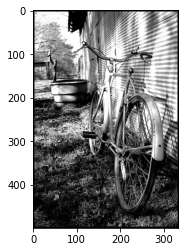

In [14]:
# Original image
img = cv2.imread("dataset/VOCdevkit_train/VOC2007/JPEGImages/000016.jpg")[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
plt.imshow(img)
plt.show()

In [15]:
data_generator = get_balance_augmentation()

In [73]:
# sum(1 for x in data_generator)

26617

In [74]:
# len(image_names)

4974

In [75]:
# len(list(data_generator))

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


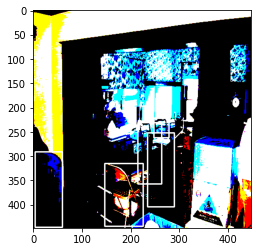

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


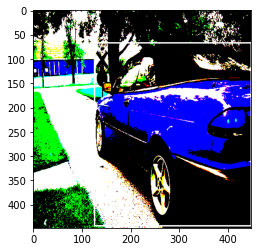

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


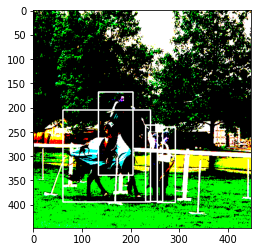

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


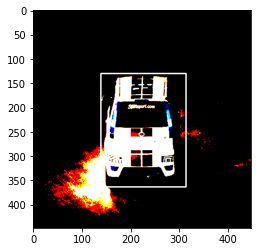

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


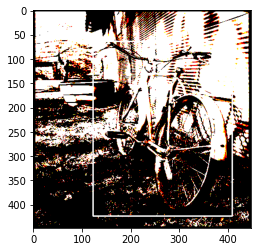

In [16]:
for i in range(5):
    x,y,z = next(data_generator)

    label = y.numpy()[0:z.numpy(),:]
    min_x = (label[:,0] - (label[:,2] / 2))
    max_x = (label[:,0] + (label[:,2] / 2))
    min_y = (label[:,1] - (label[:,3] / 2))
    max_y = (label[:,1] + (label[:,3] / 2))
    yy = np.column_stack((min_x,max_y,max_x,min_y))
    plot_img = draw_rect(x.numpy()[:,:,:],yy)
    plt.imshow(plot_img)
    plt.show()

## Object Detection Model (YOLO)

### Model

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [19]:
# # ResNet50
# #IMAGE_SIZE = 448
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.DenseNet121(input_shape=input_shape, include_top=False, weights='imagenet',classes=20)
base_model.trainable = False

inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)

x = conv_leaky_relu(x, 1024, 3, 1)
x = conv_leaky_relu(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(1024)(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470)(x)

DenseNet121 = keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121")
DenseNet121.summary()


Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 14, 14, 1024)      7037504   
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 1024)      9438208   
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 1024)     4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 1024)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 1024)      9438208   
                                                       

### Define loss

In [20]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [21]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [22]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

### Start training

In [25]:
# dataset = DatasetGenerator().generate()

In [23]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')

In [27]:
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=DenseNet121)

manager = tf.train.CheckpointManager(ckpt, './ckpts/DenseNet121_AUG', max_to_keep=3,
                                     checkpoint_name='densenet121_aug')


# CKP_DIR = 'checkpoints'
# init_epoch = 1

# ckp = tf.train.latest_checkpoint(CKP_DIR)
# if ckp:
#     resnet50.load_weights(ckp)
#     init_epoch = int(ckp.split('_')[-1]) + 1
#     print(f'Resume training from epoch {init_epoch-1}')

In [28]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = DenseNet121(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, DenseNet121.trainable_weights)
    optimizer.apply_gradients(zip(grads, DenseNet121.trainable_weights))

In [29]:
from datetime import datetime

In [30]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [31]:
EPOCHS = 3

In [32]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2021-11-24 00:47:13.735122, start training.


d:\NTHU\DL_course\competition\data_aug\bbox_util.py:88: RuntimeWarning: invalid value encountered in true_divide
  delta_area = ((ar_ - bbox_area(bbox))/ar_)


2021-11-24 01:57:36.467822, Epoch 1: loss 16.17
Saved checkpoint for epoch 1: ./ckpts/DenseNet121_AUG\densenet121_aug-1
2021-11-24 03:07:34.747035, Epoch 2: loss 11.13
Saved checkpoint for epoch 2: ./ckpts/DenseNet121_AUG\densenet121_aug-2
2021-11-24 04:17:24.578170, Epoch 3: loss 8.78
Saved checkpoint for epoch 3: ./ckpts/DenseNet121_AUG\densenet121_aug-3


### Predict test data

In [24]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [25]:
test_img_files = open('./dataset/pascal_voc_testing_data.txt')
test_img_dir = './dataset/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1
    
    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [26]:
ckpt = tf.train.Checkpoint(net=DenseNet121)
ckpt.restore('./ckpts/DenseNet121_AUG/densenet121_aug-3')

In [27]:
@tf.function
def prediction_step(img):
    return DenseNet121(img, training=False)

### Make prediction and output to txt file

In [28]:
output_file = open('./output/test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):

        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        # print("First:", xmin, ymin, xmax, ymax, class_num)
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
        # print("Second:", xmin, ymin, xmax, ymax, class_num)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

### Run evaluation metric

In [30]:
import sys
sys.path.insert(0, './evaluate')

In [31]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./output/test_prediction.txt', './output/output_file.csv')

End Evalutation
Ahhhhhhhhhhhhhhhhhh


([<evaluate.BoundingBoxes at 0x2728567bee0>,
  <evaluate.BoundingBoxes at 0x272ec80e6a0>])

## Visualization

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

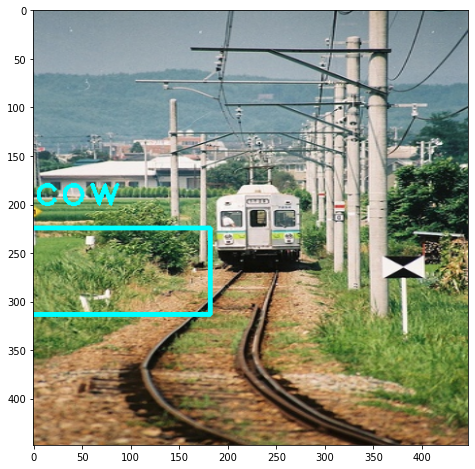

In [77]:
## 000001 000002 000003 000004 000006 000119

np_img = cv2.imread('./dataset/VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(src=np_img, dsize=(IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = DenseNet121(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.figure(figsize=(8,8))
plt.imshow(resized_img)
plt.show()

In [32]:
all_boudingBoxes, big_boundingBoxes = evaluate.evaluate('./output/test_prediction.txt', './output/output_file.csv')

End Evalutation
Ahhhhhhhhhhhhhhhhhh


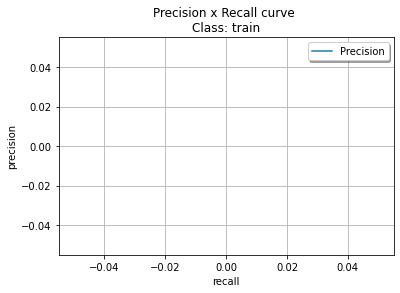

Average Precision:  0.0


In [36]:
# ["aeroplane", "bicycle", "bird", "boat", "bottle", 
#     "bus", "car", "cat", "chair", "cow", "diningtable", 
#     "dog", "horse", "motorbike", "person", "pottedplant", 
#     "sheep", "sofa", "train","tvmonitor"]

evaluator = evaluate.Evaluator()
ret = evaluator.PlotPrecisionRecallCurve("train", all_boudingBoxes[8])
print('Average Precision: ', ret['AP'])